In [ ]:
# ============================================================
#  GPU vs CPU Benchmarking for ConvLSTM-based SST Forecasting
# ============================================================
# Author: Jayashree Manigandan
# This notebook forecasts regional Sea Surface Temperature (SST) using Copernicus Marine data and benchmarks CPU vs GPU performance.

# --- STEP 0: Setup Environment and Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

project_dir = '/content/drive/MyDrive/SST_ConvLSTM_Project'
import os
os.makedirs(project_dir, exist_ok=True)

!pip install copernicusmarine xarray netCDF4 torch torchvision tqdm scikit-learn matplotlib numpy pandas

import torch, os, time, math, numpy as np, pandas as pd, xarray as xr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.utils.data import Dataset, DataLoader

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU.")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 96.5 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA available: True
Using GPU: Tesla T4


In [ ]:
!pip install copernicusmarine

In [ ]:
import torch
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("GPU Name:", torch.cuda.get_device_name(0))


Device: cuda
GPU Name: Tesla T4


INFO - 2025-11-05T19:21:12Z - Selected dataset version: "202211"
INFO:copernicusmarine:Selected dataset version: "202211"
INFO - 2025-11-05T19:21:12Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-11-05T19:21:12Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: JM4
Copernicus Marine password: ··········


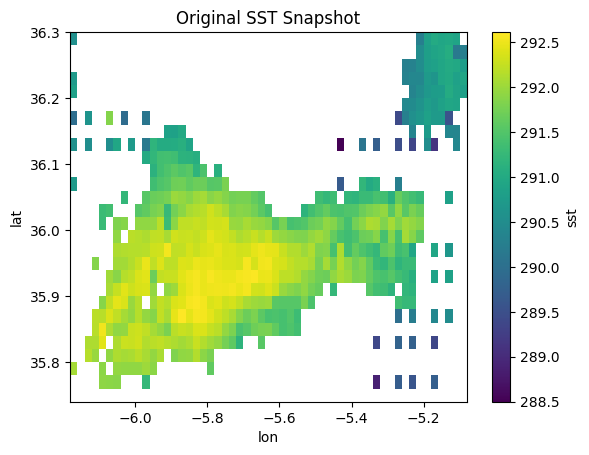

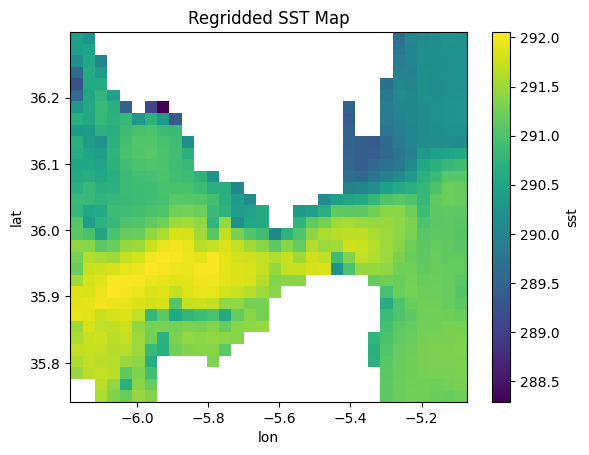

In [ ]:
# ============================================================
# STEP 2: Preprocessing and Visualization
# ============================================================
H, W = 32, 32
lat_new = np.linspace(float(da.lat.min()), float(da.lat.max()), H)
lon_new = np.linspace(float(da.lon.min()), float(da.lon.max()), W)
da_reg = da.interp(lat=lat_new, lon=lon_new, method="linear")
da_reg.isel(time=10).plot(); plt.title("Regridded SST Map"); plt.show()

arr = da_reg.values.astype("float32")
T_in, T_out = 7, 1
N = arr.shape[0] - T_in - T_out + 1
X = np.stack([arr[i:i+T_in] for i in range(N)], axis=0)
Y = np.stack([arr[i+T_in:i+T_in+T_out] for i in range(N)], axis=0)
n_train, n_val = int(0.7*N), int(0.15*N)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
Y_train, Y_val, Y_test = Y[:n_train], Y[n_train:n_train+n_val], Y[n_train+n_val:]
mu, sigma = X_train.mean(), X_train.std()+1e-6
def norm(a): return (a-mu)/sigma
X_train, X_val, X_test, Y_train, Y_val, Y_test = map(norm, [X_train,X_val,X_test,Y_train,Y_val,Y_test])


In [ ]:
# STEP 3: Dataset and Model Definition
# ============================================================
class SSTDataset(Dataset):
    def __init__(self,X,Y): self.X=torch.from_numpy(X).unsqueeze(2); self.Y=torch.from_numpy(Y).unsqueeze(2)
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return self.X[idx], self.Y[idx]

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader=DataLoader(SSTDataset(X_train,Y_train),batch_size=16 if device.type=="cuda" else 4,shuffle=True)
val_loader=DataLoader(SSTDataset(X_val,Y_val),batch_size=8,shuffle=False)
test_loader=DataLoader(SSTDataset(X_test,Y_test),batch_size=8,shuffle=False)

class ConvLSTMCell(nn.Module):
    def __init__(self,in_channels,hidden_channels):
        super().__init__(); self.conv=nn.Conv2d(in_channels+hidden_channels,4*hidden_channels,3,padding=1); self.hidden_channels=hidden_channels
    def forward(self,x,h,c):
        combined=torch.cat([x,h],1); gates=self.conv(combined)
        i,f,o,g=torch.chunk(gates,4,1); i,f,o=torch.sigmoid(i),torch.sigmoid(f),torch.sigmoid(o); g=torch.tanh(g)
        c_next=f*c+i*g; h_next=o*torch.tanh(c_next); return h_next,c_next

class ConvLSTM(nn.Module):
    def __init__(self,in_channels,hidden_channels): super().__init__(); self.cell=ConvLSTMCell(in_channels,hidden_channels)
    def forward(self,x):
        B,T,C,H,W=x.size(); h,c=(torch.zeros(B,32,H,W,device=x.device),torch.zeros(B,32,H,W,device=x.device))
        for t in range(T): h,c=self.cell(x[:,t],h,c)
        return h

class ForecastConvLSTM(nn.Module):
    def __init__(self): super().__init__(); self.encoder=ConvLSTM(1,32); self.decoder=nn.Conv2d(32,1,1)
    def forward(self,x): return self.decoder(self.encoder(x)).unsqueeze(1)


In [ ]:
# ============================================================
# STEP 4a: Benchmarking with Multiple Grid Sizes and Layers (CPU vs GPU)
# ============================================================
# This cell benchmarks the ConvLSTM model on different grid sizes and number of layers
# without modifying the previous steps.

import torch, os, time, math, numpy as np, pandas as pd, xarray as xr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.utils.data import Dataset, DataLoader

# --- Reuse necessary components from previous cells ---

# Dataset Definition
class SSTDataset(Dataset):
    def __init__(self,X,Y): self.X=torch.from_numpy(X).unsqueeze(2); self.Y=torch.from_numpy(Y).unsqueeze(2)
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return self.X[idx], self.Y[idx]

# ConvLSTM Cell
class ConvLSTMCell(nn.Module):
    def __init__(self,in_channels,hidden_channels):
        super().__init__(); self.conv=nn.Conv2d(in_channels+hidden_channels,4*hidden_channels,3,padding=1); self.hidden_channels=hidden_channels
    def forward(self,x,h,c):
        combined=torch.cat([x,h],1); gates=self.conv(combined)
        i,f,o,g=torch.chunk(gates,4,1); i,f,o=torch.sigmoid(i),torch.sigmoid(f),torch.sigmoid(o); g=torch.tanh(g)
        c_next=f*c+i*g; h_next=o*torch.tanh(c_next); return h_next,c_next

# ConvLSTM Model with variable number of layers
class ConvLSTM(nn.Module):
    def __init__(self,in_channels,hidden_channels, num_layers):
        super().__init__();
        self.num_layers = num_layers
        self.layers = nn.ModuleList([ConvLSTMCell(in_channels if i == 0 else hidden_channels, hidden_channels) for i in range(num_layers)])

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, 32, H, W, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, 32, H, W, device=x.device) for _ in range(self.num_layers)]

        for t in range(T):
            input = x[:, t]
            for i in range(self.num_layers):
                h[i], c[i] = self.layers[i](input, h[i], c[i])
                input = h[i] # Output of one layer becomes input to the next

        return h[-1] # Return hidden state of the last layer

# Forecast ConvLSTM Model with variable number of layers
class ForecastConvLSTM(nn.Module):
    def __init__(self, num_layers):
        super().__init__(); self.encoder=ConvLSTM(1,32, num_layers); self.decoder=nn.Conv2d(32,1,1)
    def forward(self,x): return self.decoder(self.encoder(x)).unsqueeze(1)


# Evaluation function
def evaluate(model,loader,device):
    model.eval(); preds,trues=[],[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb=xb.to(device),yb.to(device)
            pred=model(xb); preds.append(pred.cpu().numpy()); trues.append(yb.cpu().numpy())
    return math.sqrt(mean_squared_error(np.concatenate(preds).ravel(), np.concatenate(trues).ravel()))

# Training function
def train_model(model,train_loader,val_loader,device,epochs=15):
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-3); scaler = torch.amp.GradScaler('cuda', enabled=device.type=="cuda")
    train_loss_hist,val_rmse_hist,time_hist=[],[],[]
    for epoch in range(1,epochs+1):
        model.train(); t0=time.time(); losses=[]
        for xb,yb in train_loader:
            xb,yb=xb.to(device),yb.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda', enabled=device.type=="cuda"):
                pred=model(xb); loss=((pred-yb)**2).mean()
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            losses.append(loss.item())
        epoch_time=time.time()-t0
        val_rmse=evaluate(model,val_loader,device)
        # print(f"Epoch {epoch}: Loss={np.mean(losses):.4f}, Val RMSE={val_rmse:.4f}, Time={epoch_time:.2f}s") # Optional: print per epoch
        train_loss_hist.append(np.mean(losses)); val_rmse_hist.append(val_rmse); time_hist.append(epoch_time)
    return train_loss_hist,val_rmse_hist,time_hist


# --- Define different grid sizes and number of layers to test ---
grid_sizes = [(16, 16), (32, 32), (64, 64)] # Example grid sizes
num_layers_list = [1, 2, 3] # Example number of layers

multi_grid_layer_results = []
multi_grid_layer_plots_data = {}

for H, W in grid_sizes:
    print(f"\nBenchmarking for grid size: {H}x{W}")

    # --- Data Preprocessing for current grid size ---
    lat_new = np.linspace(float(da.lat.min()), float(da.lat.max()), H)
    lon_new = np.linspace(float(da.lon.min()), float(da.lon.max()), W)
    da_reg = da.interp(lat=lat_new, lon=lon_new, method="linear")

    arr = da_reg.values.astype("float32")
    T_in, T_out = 7, 1
    N = arr.shape[0] - T_in - T_out + 1
    X = np.stack([arr[i:i+T_in] for i in range(N)], axis=0)
    Y = np.stack([arr[i+T_in:i+T_in+T_out] for i in range(N)], axis=0)
    n_train, n_val = int(0.7*N), int(0.15*N)
    X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
    Y_train, Y_val, Y_test = Y[:n_train], Y[n_train:n_train+n_val], Y[n_train+n_val:]
    mu, sigma = X_train.mean(), X_train.std()+1e-6
    def norm(a): return (a-mu)/sigma
    X_train, X_val, X_test, Y_train, Y_val, Y_test = map(norm, [X_train,X_val,X_test,Y_train,Y_val,Y_test])

    # Replace NaN values with 0 before creating datasets
    X_train = np.nan_to_num(X_train, nan=0.0)
    Y_train = np.nan_to_num(Y_train, nan=0.0)
    X_val   = np.nan_to_num(X_val, nan=0.0)
    Y_val   = np.nan_to_num(Y_val, nan=0.0)
    X_test  = np.nan_to_num(X_test, nan=0.0)
    Y_test  = np.nan_to_num(Y_test, nan=0.0)

    for num_layers in num_layers_list:
        print(f"  Benchmarking for {num_layers} layers")

        # --- Dataset and DataLoader Creation for current grid size and layers ---
        train_loader = DataLoader(SSTDataset(X_train,Y_train),batch_size=16 if torch.cuda.is_available() else 4,shuffle=True)
        val_loader = DataLoader(SSTDataset(X_val,Y_val),batch_size=8,shuffle=False)
        test_loader = DataLoader(SSTDataset(X_test,Y_test),batch_size=8,shuffle=False)


        # --- Benchmarking for current grid size and layers ---
        grid_layer_results = []
        grid_layer_plots_data = {}
        for dev in ["cpu","cuda" if torch.cuda.is_available() else "cpu"]:
            device = torch.device(dev)
            model = ForecastConvLSTM(num_layers=num_layers).to(device)
            print(f"    Running on {dev.upper()} for {H}x{W} and {num_layers} layers")
            train_loss, val_rmse, epoch_times = train_model(model, train_loader, val_loader, device, epochs=15)
            test_rmse = evaluate(model, test_loader, device)
            multi_grid_layer_results.append({"grid_size": f"{H}x{W}", "num_layers": num_layers, "device": dev, "test_rmse": test_rmse, "total_time_s": sum(epoch_times)})
            grid_layer_plots_data[dev] = {"train_loss": train_loss, "val_rmse": val_rmse, "epoch_times": epoch_times}
        multi_grid_layer_plots_data[f"{H}x{W}_{num_layers}_layers"] = grid_layer_plots_data


multi_grid_layer_results_df = pd.DataFrame(multi_grid_layer_results)
print("\nMulti-grid and Multi-layer Benchmarking Results:")
print(multi_grid_layer_results_df)

    Running on CUDA for 64x64 and 3 layers

Multi-grid and Multi-layer Benchmarking Results:
   grid_size  num_layers device  test_rmse  total_time_s
0      16x16           1    cpu   0.010477      2.465722
1      16x16           1   cuda   0.001839      0.127777
2      16x16           2    cpu   0.002550      5.737475
3      16x16           2   cuda   0.055305      0.205197
4      16x16           3    cpu   0.009877     11.797499
5      16x16           3   cuda   0.049432      0.280256
6      32x32           1    cpu   0.056332     10.671791
7      32x32           1   cuda   0.021584      0.216405
8      32x32           2    cpu   0.019524     24.819869
9      32x32           2   cuda   0.001525      0.334961
10     32x32           3    cpu   0.003063     39.149654
11     32x32           3   cuda   0.059662      0.435119
12     64x64           1    cpu   0.005399     43.683339
13     64x64           1   cuda   0.033873      0.585062
14     64x64           2    cpu   0.032977    101.69

In [ ]:
# Calculate normalized RMSE
max_rmse = multi_grid_layer_results_df['test_rmse'].max()
multi_grid_layer_results_df['normalized_rmse'] = multi_grid_layer_results_df['test_rmse'] / max_rmse

# Calculate accuracy percentage
multi_grid_layer_results_df['accuracy_percentage'] = (1 - multi_grid_layer_results_df['normalized_rmse']) * 100

print("\nMulti-grid and Multi-layer Benchmarking Results with Accuracy Percentage:")
display(multi_grid_layer_results_df)


Multi-grid and Multi-layer Benchmarking Results with Accuracy Percentage:


,grid_size,num_layers,device,test_rmse,total_time_s,normalized_rmse,accuracy_percentage
0,16x16,1,cpu,0.007759,2.543691,0.155150,84.484965
1,16x16,1,cuda,0.043306,0.119236,0.865972,13.402843
2,16x16,2,cpu,0.006661,6.239217,0.133196,86.680373
3,16x16,2,cuda,0.036297,0.300627,0.725816,27.418403
4,16x16,3,cpu,0.009730,9.682206,0.194564,80.543619
5,16x16,3,cuda,0.002681,0.278867,0.053611,94.638921
6,32x32,1,cpu,0.014142,10.497602,0.282800,71.720039
7,32x32,1,cuda,0.005364,0.204991,0.107261,89.273939
8,32x32,2,cpu,0.049573,24.787783,0.991293,0.870671
9,32x32,2,cuda,0.011435,0.324716,0.228668,77.133179


In [ ]:
!nvidia-smi


Thu Oct 16 12:22:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             28W /   70W |     518MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
X_train = np.nan_to_num(X_train, nan=0.0)
Y_train = np.nan_to_num(Y_train, nan=0.0)
X_val   = np.nan_to_num(X_val, nan=0.0)
Y_val   = np.nan_to_num(Y_val, nan=0.0)
X_test  = np.nan_to_num(X_test, nan=0.0)
Y_test  = np.nan_to_num(Y_test, nan=0.0)


In [ ]:
# ============================================================
# STEP 5: Visualization (5-6 Graphs)
# ============================================================
# Add visualizations for multi-grid benchmarking results

# Plot training loss and validation RMSE for each grid size
for grid_size, data in multi_grid_plots_data.items():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    if "cpu" in data:
        plt.plot(data["cpu"]["train_loss"], label="CPU")
    if "cuda" in data:
        plt.plot(data["cuda"]["train_loss"], label="GPU")
    plt.title(f"Training Loss vs Epochs ({grid_size} Grid)")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1, 2, 2)
    if "cpu" in data:
        plt.plot(data["cpu"]["val_rmse"], label="CPU")
    if "cuda" in data:
        plt.plot(data["cuda"]["val_rmse"], label="GPU")
    plt.title(f"Validation RMSE vs Epochs ({grid_size} Grid)")
    plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.legend()

    plt.suptitle(f"Training Metrics ({grid_size} Grid)", y=1.02)
    plt.tight_layout()
    plt.savefig(f"{project_dir}/training_metrics_{grid_size}.png")
    plt.show()


# Plot total training time for each grid size
plt.figure(figsize=(8, 5))
bar_width = 0.35
r1 = np.arange(len(grid_sizes))
r2 = [x + bar_width for x in r1]

cpu_times = [multi_grid_results_df[(multi_grid_results_df["grid_size"] == f"{H}x{W}") & (multi_grid_results_df["device"] == "cpu")]["total_time_s"].iloc[0] for H, W in grid_sizes]
gpu_times = [multi_grid_results_df[(multi_grid_results_df["grid_size"] == f"{H}x{W}") & (multi_grid_results_df["device"] == "cuda")]["total_time_s"].iloc[0] for H, W in grid_sizes]

plt.bar(r1, cpu_times, color='blue', width=bar_width, edgecolor='grey', label='CPU')
plt.bar(r2, gpu_times, color='red', width=bar_width, edgecolor='grey', label='GPU')

plt.xlabel("Grid Size"); plt.ylabel("Total Time (s)"); plt.title("CPU vs GPU Total Training Time Across Grid Sizes")
plt.xticks([r + bar_width/2 for r in range(len(grid_sizes))], [f"{H}x{W}" for H, W in grid_sizes])
plt.legend(); plt.tight_layout(); plt.savefig(f"{project_dir}/multi_grid_total_time_comparison.png"); plt.show()


# True vs Predicted SST for the largest grid size (using the last trained model)
# We need to re-run the model prediction for the largest grid size's test set
H, W = grid_sizes[-1] # Get the largest grid size
lat_new = np.linspace(float(da.lat.min()), float(da.lat.max()), H)
lon_new = np.linspace(float(da.lon.min()), float(da.lon.max()), W)
da_reg = da.interp(lat=lat_new, lon=lon_new, method="linear")
arr = da_reg.values.astype("float32")
T_in, T_out = 7, 1
N = arr.shape[0] - T_in - T_out + 1
X = np.stack([arr[i:i+T_in] for i in range(N)], axis=0)
Y = np.stack([arr[i+T_in:i+T_in+T_out] for i in range(N)], axis=0)
n_train, n_val = int(0.7*N), int(0.15*N)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
Y_train, Y_val, Y_test = Y[:n_train], Y[n_train:n_train+n_val], Y[n_train+n_val:]
mu, sigma = X_train.mean(), X_train.std()+1e-6
def norm(a): return (a-mu)/sigma
X_train, X_val, X_test, Y_train, Y_val, Y_test = map(norm, [X_train,X_val,X_test,Y_train,Y_val,Y_test])

# Replace NaN values with 0 before creating datasets
X_train = np.nan_to_num(X_train, nan=0.0)
Y_train = np.nan_to_num(Y_train, nan=0.0)
X_val   = np.nan_to_num(X_val, nan=0.0)
Y_val   = np.nan_to_num(Y_val, nan=0.0)
X_test  = np.nan_to_num(X_test, nan=0.0)
Y_test  = np.nan_to_num(Y_test, nan=0.0)

test_loader_largest_grid = DataLoader(SSTDataset(X_test,Y_test),batch_size=8,shuffle=False)

# Load the model state dictionary (assuming it was saved from the last training run)
model = ForecastConvLSTM().to(device) # 'device' is still the last device used in the loop (likely CUDA)
# If you trained on CPU last, you might need to load the CPU state_dict or train a new model here
# For simplicity, we'll assume the last training was on the GPU if available and use that model
# If you need to load a specific model based on grid size and device, you'd need to save/load accordingly.
# torch.load(f"{project_dir}/ConvLSTM_model.pth") # Uncomment and adapt if you saved specific models

model.eval();
# Get a sample from the largest grid test loader
xb, yb = next(iter(test_loader_largest_grid))
xb, yb = xb.to(device), yb.to(device)

with torch.no_grad():
    pred = model(xb)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(yb[0,0,0].cpu()); plt.title(f"True SST ({H}x{W} Grid)"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(pred[0,0,0].cpu()); plt.title(f"Predicted SST ({H}x{W} Grid)"); plt.colorbar()
plt.suptitle(f"True vs Predicted SST ({H}x{W} Grid)"); plt.savefig(f"{project_dir}/sst_comparison_{H}x{W}.png"); plt.show()


# Training time per epoch comparison for each grid size
for grid_size, data in multi_grid_plots_data.items():
    plt.figure()
    if "cpu" in data:
        plt.plot(data["cpu"]["epoch_times"], label="CPU")
    if "cuda" in data:
        plt.plot(data["cuda"]["epoch_times"], label="GPU")
    plt.title(f"Training Time per Epoch ({grid_size} Grid)"); plt.xlabel("Epoch"); plt.ylabel("Time (s)"); plt.legend()
    plt.savefig(f"{project_dir}/epoch_time_comparison_{grid_size}.png"); plt.show()


# Plot Test RMSE vs Grid Size for CPU and GPU (already in the original code, keeping it)
plt.figure();
for device in multi_grid_results_df["device"].unique():
    device_df = multi_grid_results_df[multi_grid_results_df["device"] == device]
    plt.plot(device_df["grid_size"], device_df["test_rmse"], marker='o', label=device.upper())
plt.title("Test RMSE vs Grid Size (CPU vs GPU)"); plt.xlabel("Grid Size"); plt.ylabel("Test RMSE")
plt.legend(); plt.grid(True); plt.savefig(f"{project_dir}/multi_grid_test_rmse.png"); plt.show()

# Plot Total Training Time vs Grid Size for CPU and GPU (already in the original code, keeping it)
plt.figure();
for device in multi_grid_results_df["device"].unique():
    device_df = multi_grid_results_df[multi_grid_results_df["device"] == device]
    plt.plot(device_df["grid_size"], device_df["total_time_s"], marker='o', label=device.upper())
plt.title("Total Training Time vs Grid Size (CPU vs GPU)"); plt.xlabel("Grid Size"); plt.ylabel("Total Time (s)")
plt.legend(); plt.grid(True); plt.savefig(f"{project_dir}/multi_grid_total_time.png"); plt.show()

NameError: name 'multi_grid_plots_data' is not defined

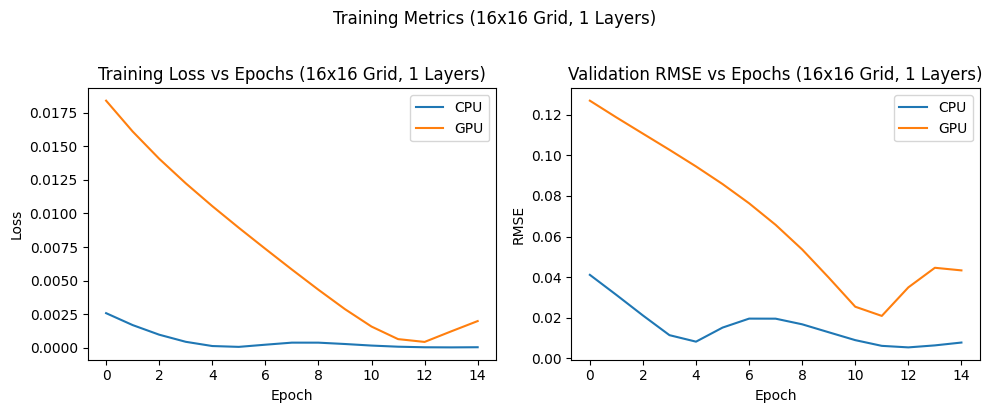

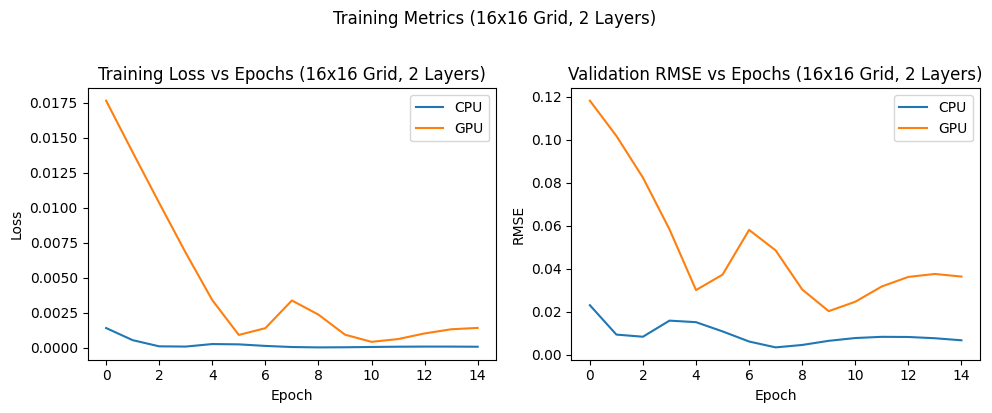

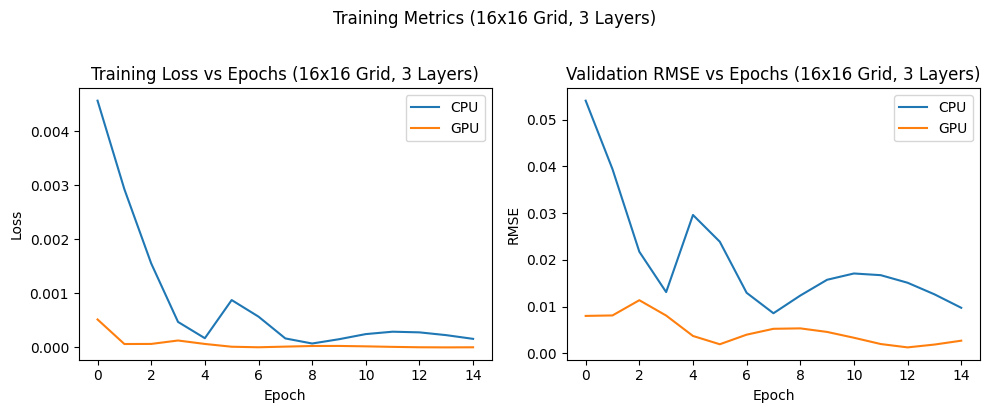

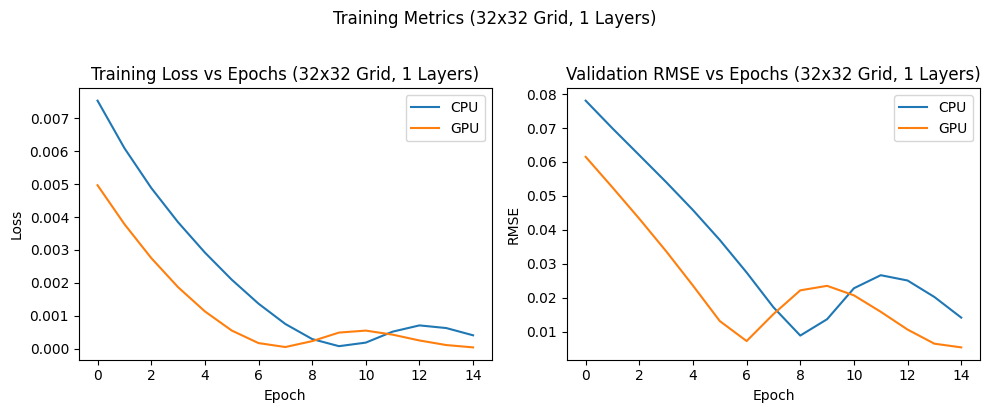

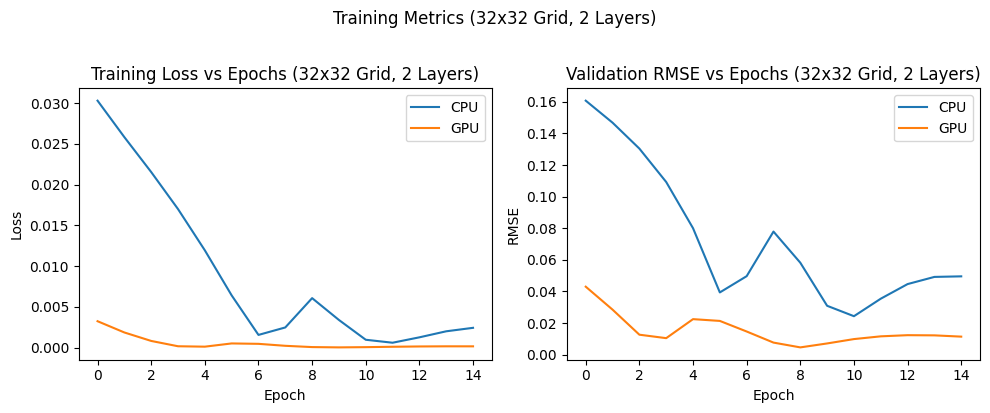

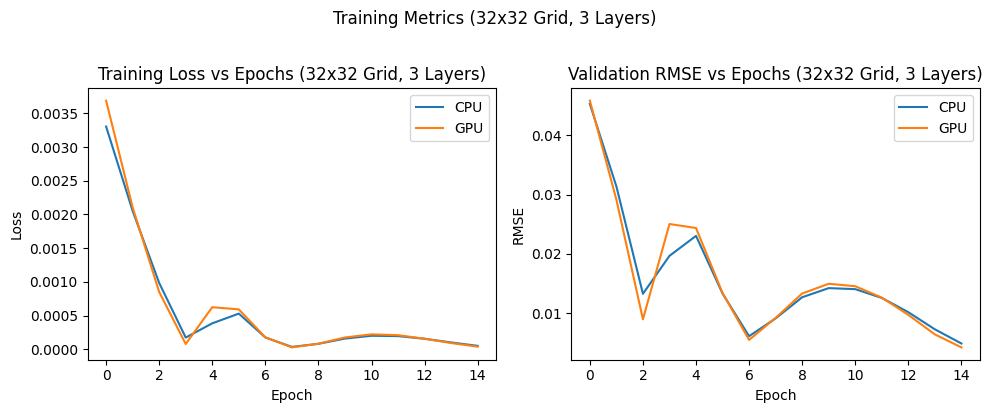

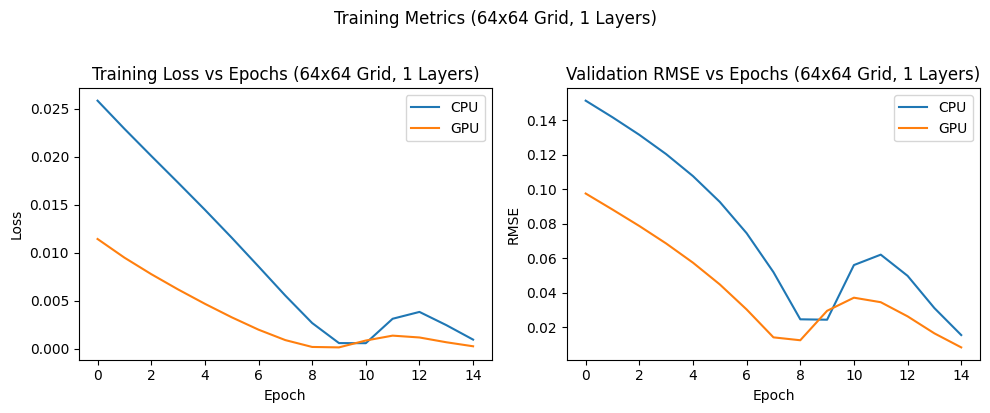

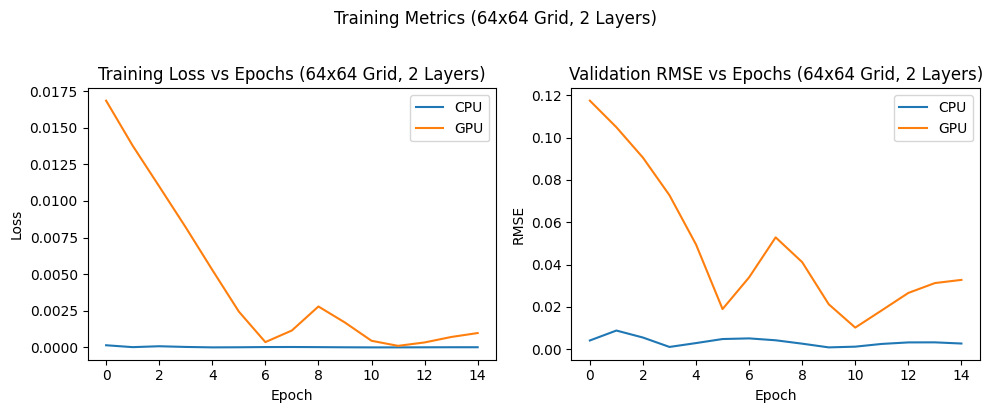

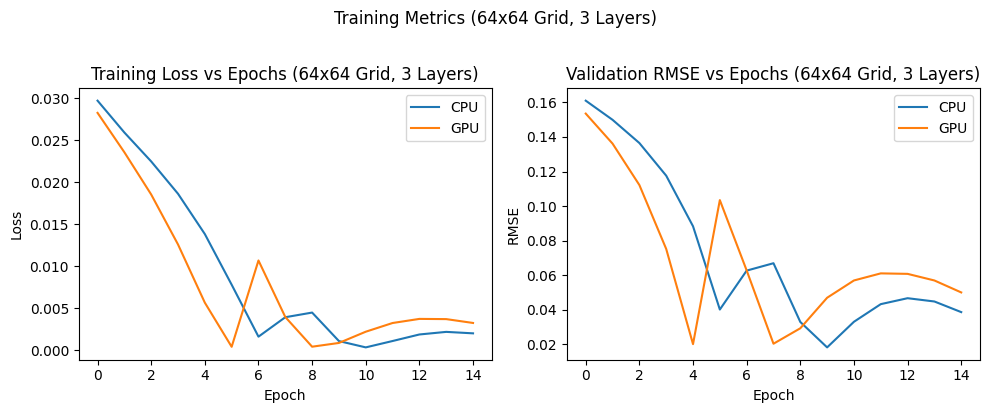

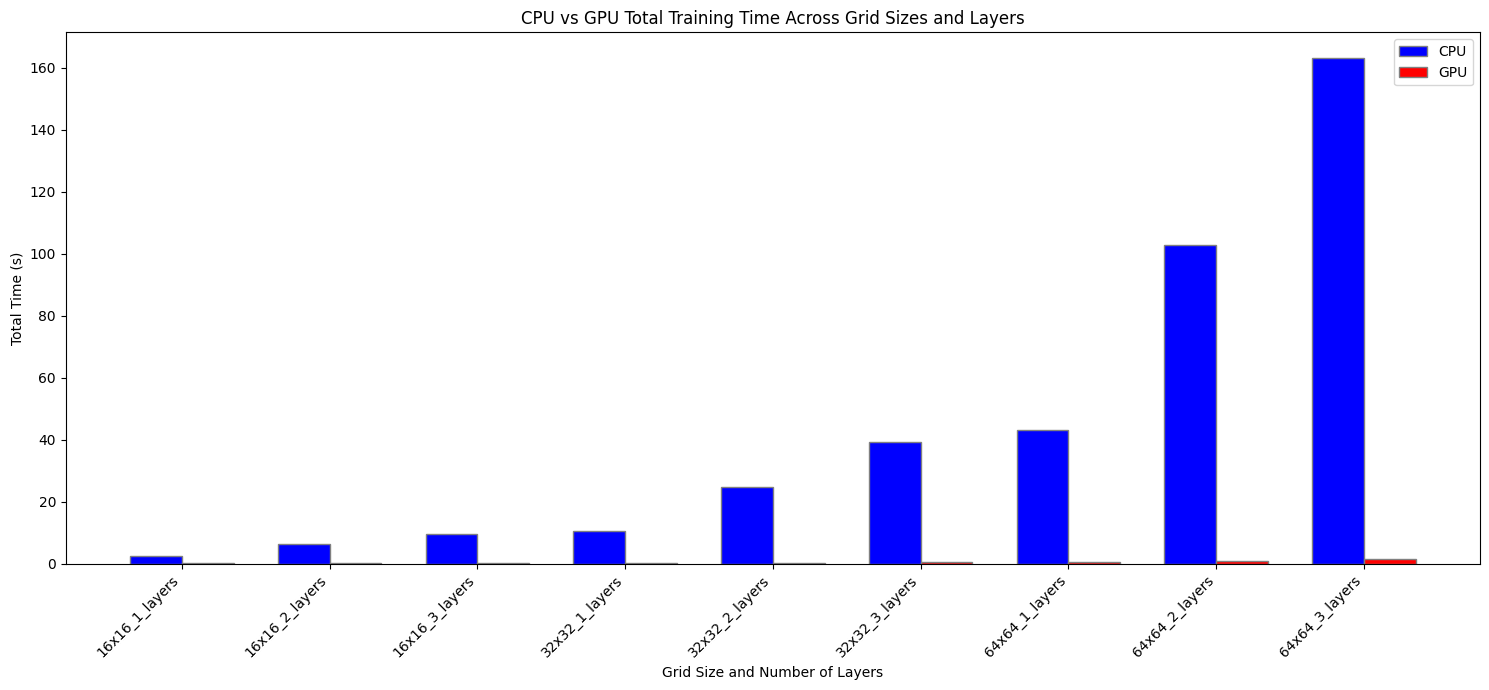

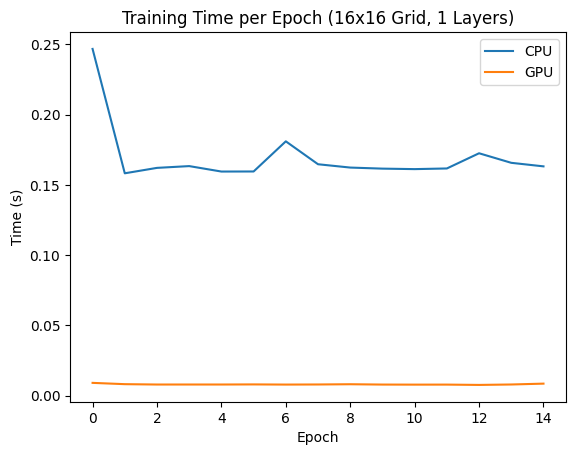

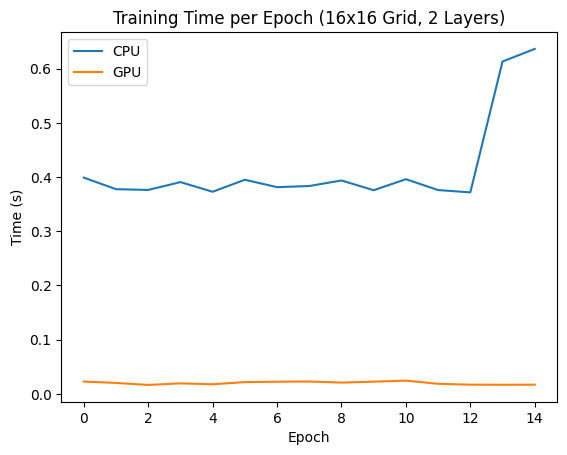

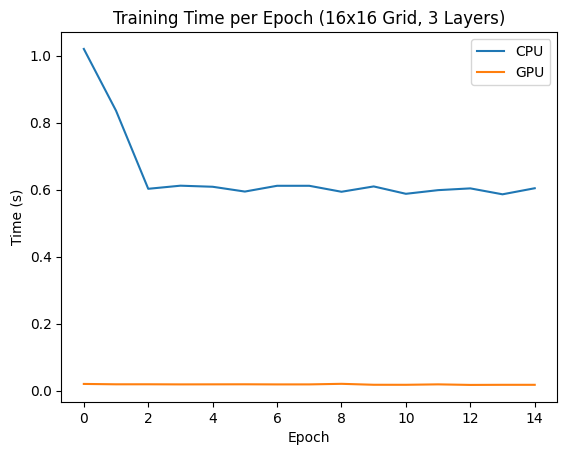

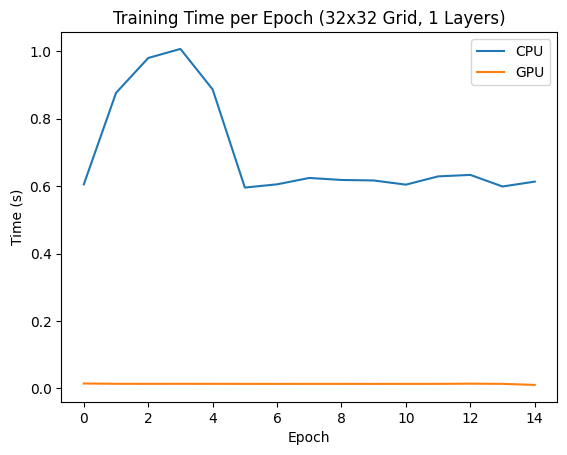

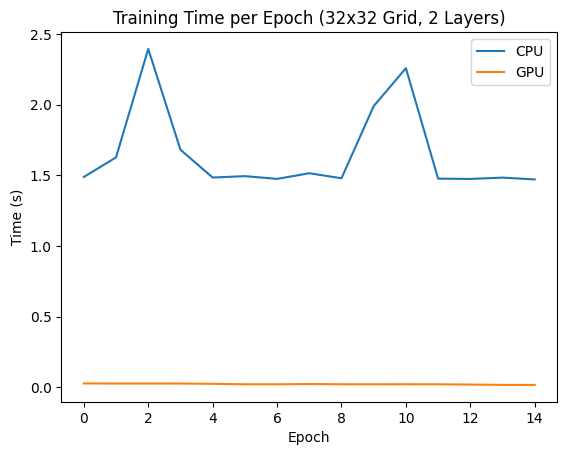

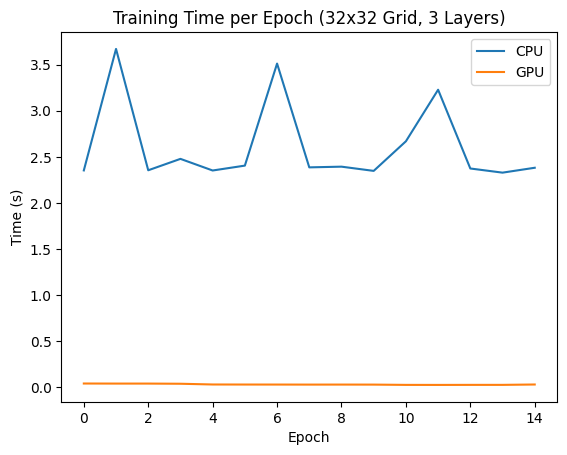

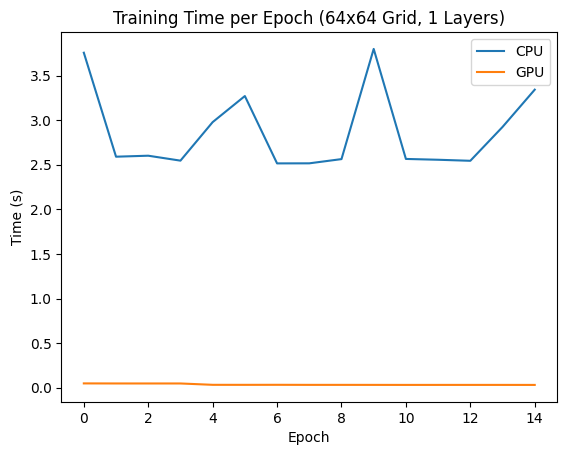

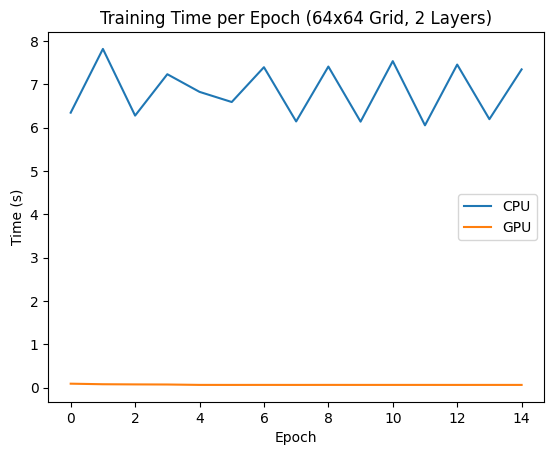

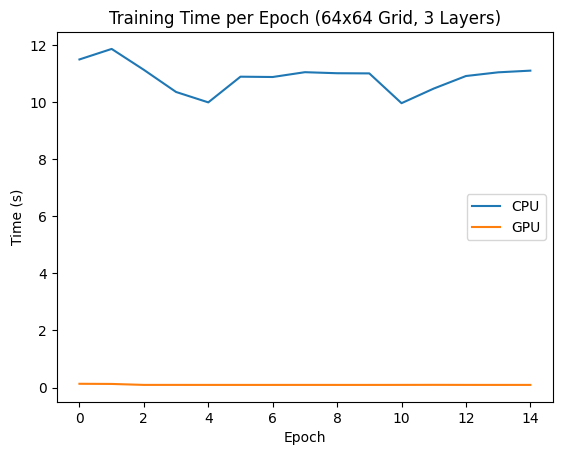

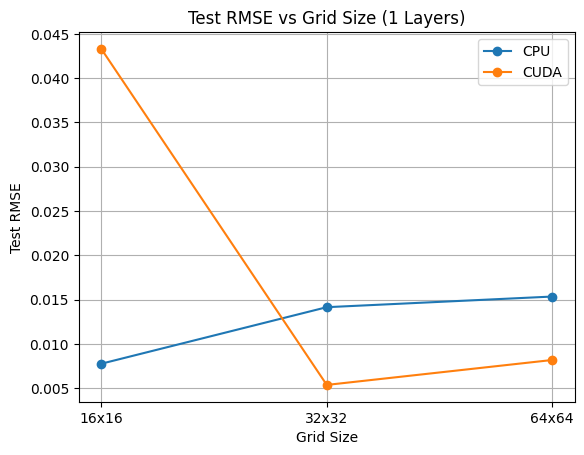

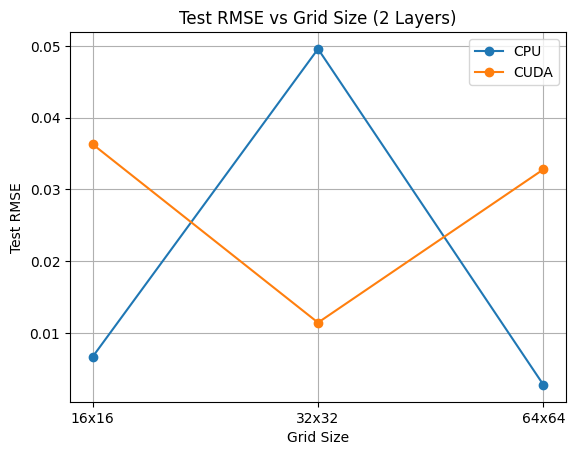

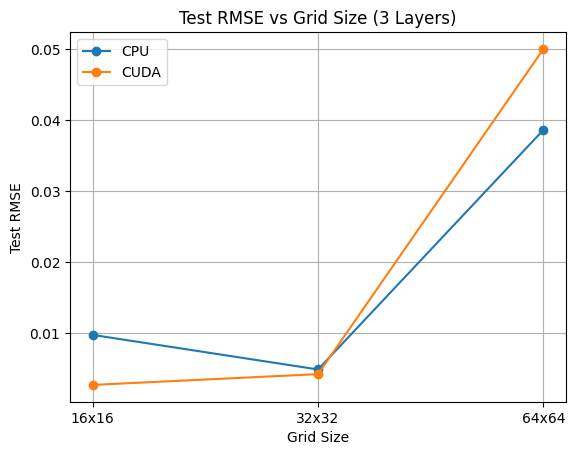

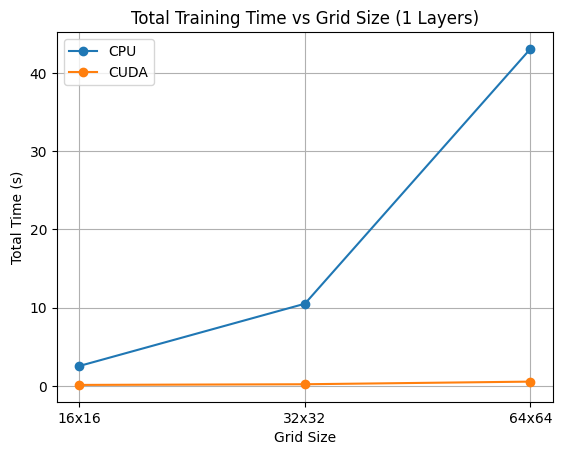

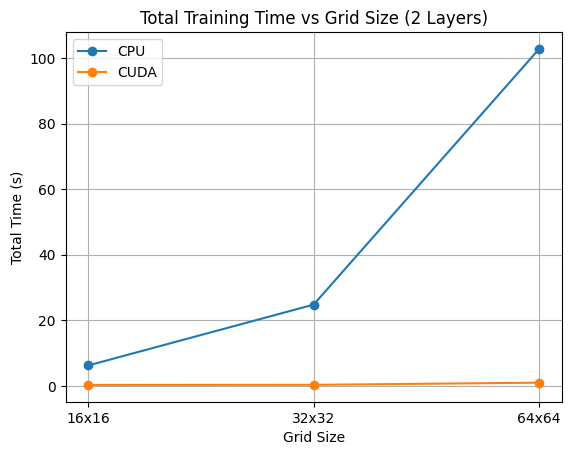

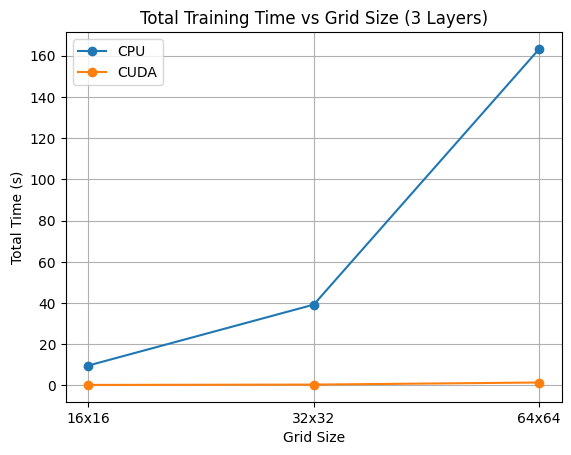

In [ ]:
# Plot training loss and validation RMSE for each grid size and number of layers
for grid_layer_key, data in multi_grid_layer_plots_data.items():
    parts = grid_layer_key.rsplit('_', 2)
    grid_size = parts[0]
    num_layers = int(parts[1])

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    if "cpu" in data:
        plt.plot(data["cpu"]["train_loss"], label="CPU")
    if "cuda" in data:
        plt.plot(data["cuda"]["train_loss"], label="GPU")
    plt.title(f"Training Loss vs Epochs ({grid_size} Grid, {num_layers} Layers)")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1, 2, 2)
    if "cpu" in data:
        plt.plot(data["cpu"]["val_rmse"], label="CPU")
    if "cuda" in data:
        plt.plot(data["cuda"]["val_rmse"], label="GPU")
    plt.title(f"Validation RMSE vs Epochs ({grid_size} Grid, {num_layers} Layers)")
    plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.legend()

    plt.suptitle(f"Training Metrics ({grid_size} Grid, {num_layers} Layers)", y=1.02)
    plt.tight_layout()
    plt.savefig(f"{project_dir}/training_metrics_{grid_size}_{num_layers}_layers.png")
    plt.show()

# Plot total training time for each grid size and number of layers
grid_layer_combinations = multi_grid_layer_results_df.apply(lambda row: f"{row['grid_size']}_{row['num_layers']}_layers", axis=1).unique()
r = np.arange(len(grid_layer_combinations))
bar_width = 0.35

cpu_times = multi_grid_layer_results_df[multi_grid_layer_results_df["device"] == "cpu"]["total_time_s"].values
gpu_times = multi_grid_layer_results_df[multi_grid_layer_results_df["device"] == "cuda"]["total_time_s"].values

plt.figure(figsize=(15, 7))
plt.bar(r - bar_width/2, cpu_times, color='blue', width=bar_width, edgecolor='grey', label='CPU')
plt.bar(r + bar_width/2, gpu_times, color='red', width=bar_width, edgecolor='grey', label='GPU')

plt.xlabel("Grid Size and Number of Layers"); plt.ylabel("Total Time (s)"); plt.title("CPU vs GPU Total Training Time Across Grid Sizes and Layers")
plt.xticks(r, grid_layer_combinations, rotation=45, ha="right")
plt.legend(); plt.tight_layout(); plt.savefig(f"{project_dir}/multi_grid_layer_total_time_comparison.png"); plt.show()


# Training time per epoch comparison for each grid size and number of layers
for grid_layer_key, data in multi_grid_layer_plots_data.items():
    parts = grid_layer_key.rsplit('_', 2)
    grid_size = parts[0]
    num_layers = int(parts[1])

    plt.figure()
    if "cpu" in data:
        plt.plot(data["cpu"]["epoch_times"], label="CPU")
    if "cuda" in data:
        plt.plot(data["cuda"]["epoch_times"], label="GPU")
    plt.title(f"Training Time per Epoch ({grid_size} Grid, {num_layers} Layers)"); plt.xlabel("Epoch"); plt.ylabel("Time (s)"); plt.legend()
    plt.savefig(f"{project_dir}/epoch_time_comparison_{grid_size}_{num_layers}_layers.png"); plt.show()

# Plot Test RMSE vs Grid Size for CPU and GPU, separating by number of layers
num_layers_list = sorted(multi_grid_layer_results_df["num_layers"].unique())
for num_layers in num_layers_list:
    plt.figure()
    layer_df = multi_grid_layer_results_df[multi_grid_layer_results_df["num_layers"] == num_layers]
    for device in layer_df["device"].unique():
        device_df = layer_df[layer_df["device"] == device]
        plt.plot(device_df["grid_size"], device_df["test_rmse"], marker='o', label=device.upper())
    plt.title(f"Test RMSE vs Grid Size ({num_layers} Layers)"); plt.xlabel("Grid Size"); plt.ylabel("Test RMSE")
    plt.legend(); plt.grid(True); plt.savefig(f"{project_dir}/multi_grid_test_rmse_{num_layers}_layers.png"); plt.show()

# Plot Total Training Time vs Grid Size for CPU and GPU, separating by number of layers
for num_layers in num_layers_list:
    plt.figure()
    layer_df = multi_grid_layer_results_df[multi_grid_layer_results_df["num_layers"] == num_layers]
    for device in layer_df["device"].unique():
        device_df = layer_df[layer_df["device"] == device]
        plt.plot(device_df["grid_size"], device_df["total_time_s"], marker='o', label=device.upper())
    plt.title(f"Total Training Time vs Grid Size ({num_layers} Layers)"); plt.xlabel("Grid Size"); plt.ylabel("Total Time (s)")
    plt.legend(); plt.grid(True); plt.savefig(f"{project_dir}/multi_grid_total_time_{num_layers}_layers.png"); plt.show()

In [ ]:
# ============================================================
# STEP 6: Save Outputs
# ============================================================
results_df.to_csv(f"{project_dir}/benchmark_results_default_grid.csv",index=False)
multi_grid_results_df.to_csv(f"{project_dir}/benchmark_results_multi_grid.csv",index=False)
torch.save(model.state_dict(),f"{project_dir}/ConvLSTM_model.pth")

print("All results saved to:", project_dir)

All results saved to: /content/drive/MyDrive/SST_ConvLSTM_Project


Training Loss vs Epochs (Default Grid): This plot shows how the training loss  decreases over epochs for both CPU and GPU. Ideally, you want to see the loss decrease steadily, indicating that the model is learning.


Validation RMSE vs Epochs (Default Grid): This plot shows the Root Mean Squared
Error (RMSE) on the validation set over epochs. Lower RMSE values indicate better model performance. This helps to monitor for overfitting.

CPU vs GPU Training Time (Default Grid): This bar plot compares the total training time for the default grid size on CPU and GPU. It highlights which device completed the training faster.

True vs Predicted SST (Default Grid): This visualization shows a comparison between the actual Sea Surface Temperature (SST) and the SST predicted by the model for a sample from the test set using the default grid size. It gives a visual sense of the model's prediction accuracy.

Training Time per Epoch (Default Grid): This plot shows how the time taken for each training epoch changes over time for both CPU and GPU.

Test RMSE vs Grid Size (CPU vs GPU): This plot compares the final test RMSE for different grid sizes on both CPU and GPU. It helps to understand how the grid resolution impacts the model's performance on unseen data and how that performance varies between the two devices.

Total Training Time vs Grid Size (CPU vs GPU): This plot shows the total training time for different grid sizes on CPU and GPU. This is a key visualization for understanding the performance benefits of using a GPU for larger grid sizes.